# English

In [36]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

In [37]:
background = np.ones((80,200,3) , dtype = 'uint8') * 200
background = Image.fromarray(background)

In [38]:
draw = ImageDraw.Draw(background)

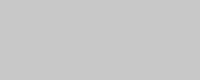

In [39]:
background

In [40]:
draw

In [41]:
font = ImageFont.truetype('Redressed-Regular.ttf', size=45)

In [42]:
font

In [43]:
message = "Hello!"
color = (0,0,128)

In [44]:
(x, y) = (30, 20)
draw.text((x, y), message, fill=color, font=font)

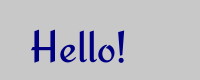

In [45]:
background

# Persian

In [46]:
import PIL
import arabic_reshaper
from PIL import Image, ImageDraw, ImageFont
from bidi.algorithm import get_display

In [95]:
background = np.ones((80,400,3) , dtype = 'uint8') * 200
background = Image.fromarray(background)
draw = ImageDraw.Draw(background)
font = ImageFont.truetype('A Badkhat.ttf', size=60)

In [96]:
raw_test = 'پروژه ی تشخیص متن فارسی'

In [97]:
reshaped_text = arabic_reshaper.reshape(raw_test)
bidi_text = get_display(reshaped_text)
color = (0,0,128)
(x, y) = (0, 0)
draw.text((x, y), bidi_text, fill=color, font=font)

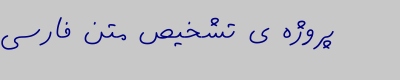

In [98]:
background

# Dataset Creation

In [99]:
import PIL
import arabic_reshaper
from PIL import Image, ImageDraw, ImageFont
from bidi.algorithm import get_display
import os
from glob import glob

In [101]:
fonts_names = glob('fonts/*ttf')
corpus_names = glob('word_bank/*txt')

In [151]:
def create_word(word, font_name, bg = None , size = 60 , word_loc = (0,0), color = (0,0,128) , bg_size = (80,400), bg_color = (200)):
    if bg is None:
        background = np.ones((*bg_size,3) , dtype = 'uint8') * bg_color
        background = background.astype('uint8')
        background = Image.fromarray(background)
    else : bg = Image.open(bg)
    
    draw = ImageDraw.Draw(background)
    font = ImageFont.truetype(font_name, size=size)
    reshaped_text = arabic_reshaper.reshape(word)
    bidi_text = get_display(reshaped_text)
    color = (0,0,128)
    x, y = word_loc
    draw.text((x, y), bidi_text, fill=color, font=font)
    return background

In [179]:
def get_all_fonts(fonts_dir):
    fonts_names = glob(os.path.join(fonts_dir , '*ttf'))
    print(f'Found {len(fonts_names)} fonts in the given directory')
    return fonts_names

In [180]:
def get_all_words(corpuses_dir):
    all_words = []
    corpus_names = glob(os.path.join(corpuses_dir , '*txt'))
    print(f'There are {len(corpus_names)} text files in the corpus')
    for txt_file in corpus_names:
        file = open(txt_file)
        lines = file.read()
        all_words.extend(lines.split('\n'))
    print(f'Found {len(all_words)} words in the dataset.')
    return all_words

In [181]:
all_words = get_all_words('word_bank/')
all_fonts = get_all_fonts('fonts/')

There are 2 text files in the corpus
Found 10 words in the dataset.
Found 2 fonts in the given directory


In [182]:
output_dir = 'outputs/'
os.makedirs(output_dir , exist_ok = True)

In [193]:
counter = 0
for w_idx, word in enumerate(all_words):
    for f_idx, font in enumerate(all_fonts):
        img = create_word(word, font_name= font)
        img.save(os.path.join(output_dir , f'w_{w_idx:04d}f_{f_idx:04d}.png' ))
#         img.save(os.path.join(output_dir , f'{counter:03d}.png' ))
        counter += 1

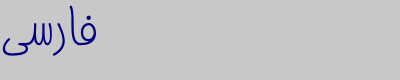

In [190]:
f'{5:02d}'

'05'